# Understanding the Amazon rainforest from space

## Overview of Section
1. Split of test data/training data Justification
2. Weather models (Multi-classifier single labels)
3. Single Label Land Approach
4. Multi-label land approach
5. Combined Land/Weather approach


Given we are mostly interested in being able to tell where deforestation is occuring, we will simplify the land tags into naturally occuring phenomena 



In [1]:
import numpy as np # linear algebra
import pandas as pd 
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
import seaborn as sns

import random
import math
from skimage import io
import itertools
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.multioutput import ClassifierChain
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
import warnings
warnings.filterwarnings('ignore')

D:\Applications\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Applications\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. Split of test training data
We are choosing to split the data 90 to 10 training to test. This is because we want to keep as much information for learning as possible while still retaining a reasonable sample size >2000 for testing.

We will also scale the data, to ensure that no feature is overweighted.

In [2]:
#obtain processed training labels and data
labels = pd.read_csv('train_labels_clean.csv')

data = pd.read_csv('train_data.csv')
## sclae the data so nothing is dominating
min_max_scaler = preprocessing.MinMaxScaler()
data_minmax = min_max_scaler.fit_transform(data)



# Create training and test sets for weather labels by randomly splitting the original dataset as 90%/10%
train_data_weather, test_data_weather, train_labels_weather, test_labels_weather = train_test_split(data_minmax, labels.weather, test_size=0.1)
# Create training and test sets for land labels by randomly splitting the original dataset as 90%/10%
train_data_land, test_data_land, train_labels_land, test_labels_land = train_test_split(data_minmax, labels.land, test_size=0.1)
# Create training and test sets for multi-label land labels by randomly splitting the original dataset as 90%/10%
labels['tags_split'] = labels['land'].map(lambda row: row.split(" "))

#turn the labels into matrix for multi label analyses
mlb = MultiLabelBinarizer()
multi_labels_land = mlb.fit_transform(labels['tags_split'])
multi_labels_combined = mlb.fit_transform(labels['combined_tags'])
train_data_land_multi, test_data_land_multi, train_labels_land_multi, test_labels_land_multi= train_test_split(data_minmax, multi_labels_land, test_size=0.1)
train_data_combined, test_data_combined, train_labels_combined, test_labels_combined= train_test_split(data_minmax, multi_labels_combined, test_size=0.1)

## Weather feature identification

Weather feature identification is being performed for cloud and haze removal. This facilitates the successive water, land and primary feature identification.

1. Create Useful fucntions
2. Try a variety of models
3. Improve on the most successful model preformance

 ## 1. Output Functions
 

In [3]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def single_model_output(pipeline, scores, train_data, train_label, test_data, test_label):
    pipeline.fit(train_data,train_label)
    model_predictions=pipeline.predict(test_data)

    print("Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 

    con_fu=confusion_matrix(test_label, model_predictions)
    class_list=sorted(list(set(test_label)))
    return plot_confusion_matrix(con_fu, classes=class_list)

def multiple_model_output(pipeline, scores, train_data, train_label, test_data, test_label):
    pipeline.fit(train_data,train_label)
    model_predictions=pipeline.predict(test_data)
    
    print(classification_report(test_label,model_predictions))
    
    return "Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

## 2. Logistic Regression

In [6]:
# Setup the pipeline for logistics regression
LG_model =LogisticRegression(tol=0.02)
LG_pipeline = Pipeline([
    ('LogisticsRegression', LG_model),
])

LG_scores = cross_val_score(LG_pipeline,
                            train_data_weather,
                            train_labels_weather,
                            cv=10,
                            scoring='f1_micro')

Cross-Validation
 Accuracy: 0.88 (+/- 0.01)


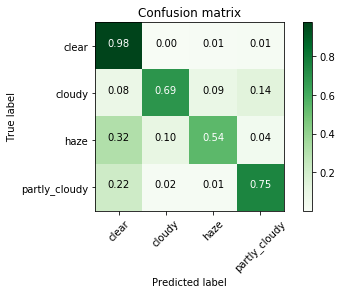

In [7]:
# Check output for Logistics Regression
single_model_output(LG_pipeline, LG_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

This model works okay for clear weather - but not really for anything else, we can see it's biasing the result toward the biggest sample, though interestingly it confuses cloudy for everything else. Log Reg probably not the way to go. So we won't spend too much time playing with the paramaters of the model.


In [12]:
# Setup the pipeline for decision tree. Use GridSearchCV to find the best depth for decision tree
param_grid = dict(DecisionTrees__max_depth=[5,10,20,50,100], DecisionTrees__min_samples_leaf=[2,5,10,15,20,25])
DT_model=DecisionTreeClassifier()
DT_pipeline = Pipeline([
    ('DecisionTrees', DT_model),
])

grid_tree = GridSearchCV(DT_pipeline, param_grid)
grid_tree.fit(train_data_weather, train_labels_weather)
tree_preds = grid_tree.predict(test_data_weather)

In [13]:
print("The best tree parameters are: " + str(grid_tree.best_params_))

The best tree parameters are: {'DecisionTrees__max_depth': 100, 'DecisionTrees__min_samples_leaf': 20}


In [14]:
# Set up the pipeline for decision tree with the best depth = 100, samples =20
DT_model_best =DecisionTreeClassifier(min_samples_leaf=20, max_depth=100)
DT_pipeline_best = Pipeline([
    ('DecisionTrees', DT_model_best),
])

DT_scores = cross_val_score(DT_pipeline_best,
                            train_data_weather,
                            train_labels_weather,
                            cv=10,
                            scoring='f1_micro')

Cross-Validation
 Accuracy: 0.87 (+/- 0.01)


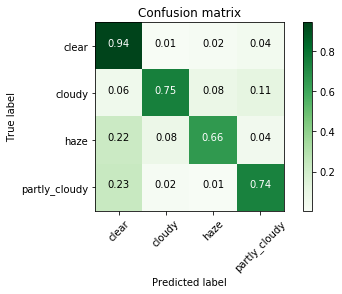

In [28]:
# Check output for Decision Tree
single_model_output(DT_pipeline_best, DT_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

Even though the cross-validation score is lower - we could prefer this model to Logistic Regression because it does better with the rare labels. 

We can see that it improves the predictions on both cloudy and haze but it makes partly cloudly slightly worse.

In [4]:
# Setup the pipeline for random forest. Use GridSearchCV to find the best parameters 
param_grid = dict(RandomForest__max_depth=[20,50,75],
                 RandomForest__n_estimators = [20,50,100],
                 RandomForest__min_samples_leaf = [5,10,20])

RF_model =RandomForestClassifier()
RF_pipeline = Pipeline([
    ('RandomForest', RF_model),
])

grid_forest = GridSearchCV(RF_pipeline, param_grid)
grid_forest.fit(train_data_weather, train_labels_weather)
forest_preds = grid_forest.predict(test_data_weather)

In [5]:
print("The best tree parameters are: " + str(grid_forest.best_params_))

The best tree parameters are: {'RandomForest__max_depth': 75, 'RandomForest__min_samples_leaf': 5, 'RandomForest__n_estimators': 50}


In [7]:
# Set up the pipeline for random forest with the best parameters
RF_model_best =RandomForestClassifier(n_estimators=75, min_samples_leaf=5,max_depth=50)
RF_pipeline_best = Pipeline([
    ('RandomForest', RF_model_best),
])

RF_scores = cross_val_score(RF_pipeline_best, 
                                          train_data_weather,
                                          train_labels_weather, 
                                          cv=10,
                                          scoring='f1_micro')

Cross-Validation
 Accuracy: 0.90 (+/- 0.01)


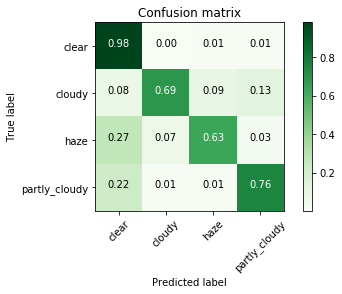

In [27]:
# Check output for Random Forest
single_model_output(RF_pipeline_best, RF_scores, train_data_weather, train_labels_weather, test_data_weather, test_labels_weather)

This is now a fairly accurate model for the clear and partly cloudy models. Hazy is still getting confused with primary and clouds are getting confused for everything. We saw from our EDA - that quite a lot of the clear pictures appear hazy so perhaps this is why. We'll examine some of the hazt pictures to see why they're getting them so wrong.

We note that this would be our preferred model due to the relatively high cross validation score and that the images. Let's look at why it's predicting the haze tagg quite so pporly.

In [ ]:
## show what's important for rf
forest = RF_model_best

forest.fit(train_data_weather, train_data_labels)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Display Misclassification

In [8]:
# Generating a list of misclassification where the original label is haze but the predicted label is not haze
RF_pipeline_best.fit(train_data_weather,train_labels_weather)
RF_predictions=RF_pipeline_best.predict(test_data_weather)
true_label_haze_index = pd.Index([i for i, e in enumerate(train_labels_weather) if e == 'haze'])
predict_label_non_haze_index = pd.Index([i for i, e in enumerate(RF_predictions) if e != 'haze'])
intersect_list = list(true_label_haze_index.intersection(predict_label_non_haze_index))
predict_label = [RF_predictions[i] for i in intersect_list]
print("The number of images that are misclassified: " + str(len(intersect_list)))

The number of images that are misclassified: 265


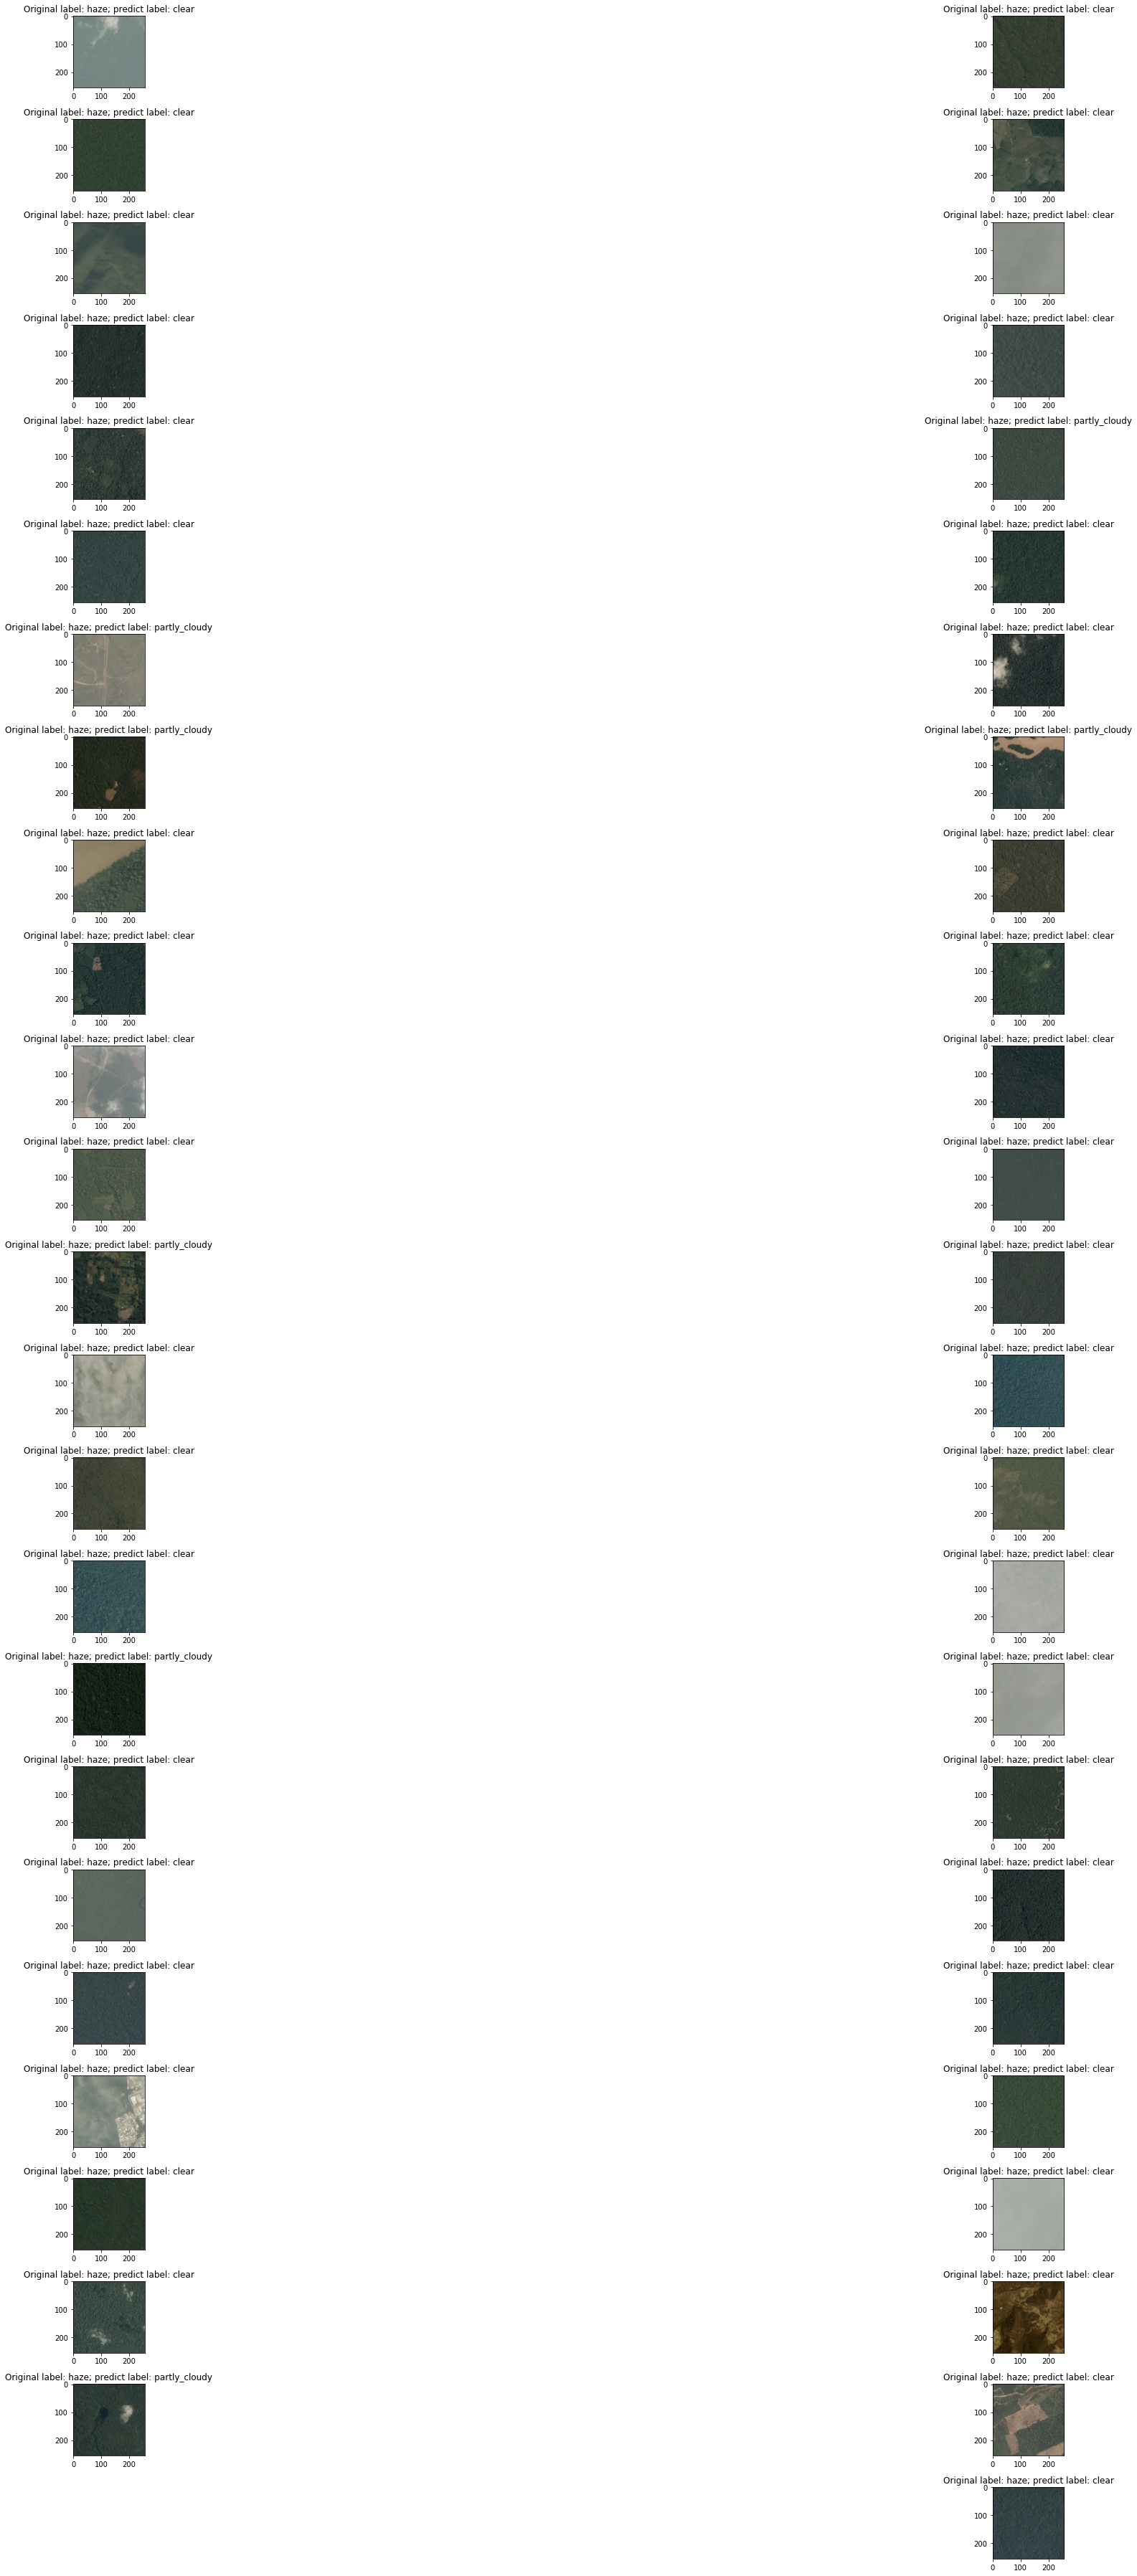

In [9]:
# Graphs for 50 misrepresentation
train_path1='C:/Users/wiw50/Desktop/W207/Final Project/train_jpg/'
plt.figure(figsize=(50,50))
j = 0
for i in intersect_list[:50]:
    plt.subplot(25,2,j+1)
    image_number = labels.iloc[[i]]['image_name'].values
    image_path = train_path1+image_number+".jpg"
    plt.imshow(plt.imread(image_path[0]))
    plt.tight_layout()
    plt.title("Original label: haze; predict label: " + str(predict_label[j]))  
    j += 1

After reviewing the above 50 misclassified samples, our observations are:

1. Not all original labels seem to be correct. Since original labels were labeled by human beings, it makes sense for us to find some errors.

2. There are total 15 images that we think the original 'haze' label is incorrect. 

3. The rest 35 images are 'haze' but our prediction model labeled incorrectly. 

## 2. Land Models - single label models

In [ ]:
# Setup the pipeline for random forest. Use GridSearchCV to find the best parameters 
param_grid = dict(RandomForest__max_depth=[5, 10,20,50,75],
                 RandomForest__n_estimators = [20,50,100,200],
                 RandomForest__min_samples_leaf = [2,3,4,5,10])
RF_model_land =RandomForestClassifier()
RF_pipeline_land = Pipeline([
    ('RandomForest', RF_model_land),
])

grid_forest_land = GridSearchCV(RF_pipeline_land, param_grid)
grid_forest_land.fit(train_data_land, train_label_land)
forest_preds_land = grid_forest_land.predict(test_data_land)

In [ ]:
print("The best tree depth is: " + str(grid_forest_land.best_params_))

In [ ]:
# Set up the pipeline for random forest with the best parameters
RF_model_land_best =RandomForestClassifier(n_estimators=100, min_samples_leaf=2,max_depth=10)
RF_pipeline_land_best = Pipeline([
    ('RandomForest', RF_model_land_best),
])

RF_land_scores = cross_val_score(RF_pipeline_land_best, 
                                          train_data_land,
                                          train_labels_land, 
                                          cv=10,
                                          scoring='f1_micro')

In [ ]:
# Check output for Random Forest
single_model_output(RF_pipeline_land_best, RF_land_scores, train_data_land, train_labels_land, test_data_land, test_labels_land)

The model does extremely badly on picking up models with water - it is fairly efficient at picking up primary and primary tags vs other, but basically nothing else. 

This is clearly not a good model, as by forcing the labels to separate we lose all the predictive power contained in other labels. I.e. what's in a primary water image, will hopefully help use to predict whats in a water other tag as well.

# Multi-label models for land

In [48]:
#GridSearchCV function for One vs. Rest (OVR) models
def multi_gridsearchcv(param_grid, model, train_data, train_labels, test_data):
    model_tuning=GridSearchCV(model, param_grid)
    model_tuning.fit(train_data, train_labels)
    print("The best parameters for the model are : " +str(model_tuning.best_params_))

In [49]:
#Pipeline for OVR models
def multi_pipeline(model, estimator, train_data, train_labels, test_data, test_labels, scoring='f1_micro', cv=10):
    multi_pipe = Pipeline([
        (estimator,model),
    ])
    multi_scores = cross_val_score(multi_pipe, 
                                 train_data,
                                 train_labels,
                                 scoring=scoring,
                                 cv=cv
                                )
    
    multiple_model_output(multi_pipe, multi_scores, train_data, train_labels, test_data, test_labels)

### One vs. Rest

#### OVR-Random Forest

In [5]:
#Run GridSearchCV for OVR model with Random Forest Estimator

#Parameter grid for final draft
'''param_grid = {'estimator__max_depth':[5,10,20,50,75], 
              'estimator__n_estimators':[20,50,100,200],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10],
                                  'estimator__n_estimators':[20,50],
                                  'estimator__min_samples_leaf':[2,3]},
                 model = OneVsRestClassifier(RandomForestClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

The best parameters for the model are : {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 3, 'estimator__n_estimators': 50}


             precision    recall  f1-score   support

          0       0.85      0.68      0.76       219
          1       0.82      0.81      0.82      1553
          2       0.97      0.99      0.98      3744
          3       0.87      0.59      0.70       750

avg / total       0.92      0.89      0.90      6266

Cross-Validation
 Accuracy: 0.90 (+/- 0.00)


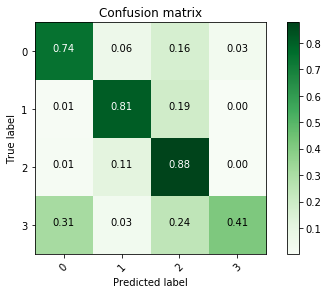

In [8]:
#Get classification report and confusion matrix for OVR model with Random Forest Estimator
multi_pipeline(model=OneVsRestClassifier(RandomForestClassifier(n_estimators=100, min_samples_leaf=2,max_depth=10)),
             estimator='RandomForest',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

We can see that model is now predicting water reasonably well, and the none tag about as well as the weather model was. 

The most important thing is that ti's getting the forest tag right with high recall and precision, so we know when and 

It's also predicting the other tag well - which is impressive when we consider how many different types of information can be contained at other.

With the way we've reduce the size of the photo we may be just losing too much of the information about water to be able to predict it.

#### OVR-Decision Tree

In [29]:
#Run GridSearchCV for OVR model with Decision Tree Estimator
'''param_grid = {'estimator__max_depth':[5,10,20,50,75],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[50,75],
                              'estimator__min_samples_leaf':[5,10]},
                 model = OneVsRestClassifier(DecisionTreeClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

The best parameters for the model are : {'estimator__max_depth': 50, 'estimator__min_samples_leaf': 10}


In [37]:
#Get classification report and confusion matrix for OVR model with Decision Tree Estimator
multi_pipeline(model=OneVsRestClassifier(DecisionTreeClassifier(max_depth=50, min_samples_leaf=10)),
             estimator='DecisionTrees',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

             precision    recall  f1-score   support

          0       0.75      0.69      0.72       212
          1       0.80      0.77      0.79      1533
          2       0.98      0.98      0.98      3749
          3       0.65      0.59      0.62       719

avg / total       0.89      0.87      0.88      6213



We can see the one vs rest classifier for decision tree is slightly outperformed by the random forest. 

Interestingly the model isn't picking too many false positives (i.e. precision), but is picking a lot of false negatives(i.e. recall). This suggests we're missing too many features pick up land masses, roads and waters, or that we're losing too much information with our data processing steps.

### Classifier Chains

#### Classifier Chains-Random Forest

In [ ]:
#Run GridSearchCV for Classifier Chain Model with Random Forest estimator
'''param_grid = {'estimator__max_depth':[5,10,20,50,75], 
              'estimator__n_estimators':[20,50,100,200],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10],
                                  'estimator__n_estimators':[20,50],
                                  'estimator__min_samples_leaf':[2,3]},
                 model = ClassifierChain(RandomForestClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

In [ ]:
#Get classification report and confusion matrix for Classifier Chain Model with Random Forest estimator
multi_pipeline(model=ClassifierChain(RandomForestClassifier(n_estimators=100, min_samples_leaf=2,max_depth=10)),
             estimator='RandomForest',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

#### Classifier Chains-Decision Tree

In [ ]:
#Run GridSearchCV for Classifier Chain Model with Decision Trees estimator
'''param_grid = {'estimator__max_depth':[5,10,20,50,75],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10],
                              'estimator__min_samples_leaf':[2,3]},
                 model = ClassifierChain(DecisionTreeClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

In [ ]:
#Get classification report and confusion matrix for Classifier Chain Model with Decision Trees estimator
multi_pipeline(model=ClassifierChain(DecisionTreeClassifier(max_depth=50, min_samples_leaf=10)),
             estimator_name='DecisionTrees',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

### Multi-Label supported algorithms, K-Nearest Neighbors

In [ ]:
def k_neighbors_model(k,data_train,labels_train,data_test,labels_test):
    model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree').fit(data_train, labels_train)
    model_predict=model.predict(data_test)
    print(classification_report(labels_test,model_predict))
#     cross_validation(model, data_train, labels_train)
#     confusion_mat(labels_test.argmax(axis=1), model_predict.argmax(axis=1))
for i in [1,5,10,12,13]:
    print("K-Neighbors: " + str(i))
    k_neighbors_model(i,train_data_land_multi,train_labels_land_multi,test_data_land_multi,test_labels_land_multi)   

K-nearest neigbours, is not a useful method, as it is getting the rare tags wrong too often. This makes it less likely to be a useful model for us.  We will stick with the classifier chain models, and the ovr defined above. Let's see what happens when we try land and weather tags together.


# Combined weather and Land Modles
Given random forests worked best for both land and weather we'll try just using them for the combined models.

In [ ]:
#Run GridSearchCV for OVR model with Random Forest Estimator

#Parameter grid for final draft
'''param_grid = {'estimator__max_depth':[5,10,20,50,75], 
              'estimator__n_estimators':[20,50,100,200],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[75,100],
                                  'estimator__n_estimators':[20,50],
                                  'estimator__min_samples_leaf':[5,10,20]},
                 model = OneVsRestClassifier(RandomForestClassifier()),
                 train_data=train_data_combined,
                 train_labels=train_labels_combined,
                 test_data=test_data_combined
                )

In [ ]:
multi_pipeline(model=OneVsRestClassifier(RandomForestClassifier(n_estimators=75, min_samples_leaf=2,max_depth=10)),
             estimator='RandomForest',
             train_data=train_data_combined,
             train_labels=train_labels_combined,
             test_data=test_data_land_combined,
             test_labels=test_labels_land_combined
            )

In [ ]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Classifier Chain - RF

In [ ]:
#Run GridSearchCV for Classifier Chain Model with Decision Trees estimator
'''param_grid = {'estimator__max_depth':[5,10,20,50,75],
              'estimator__min_samples_leaf':[2,3,4,5,10]}'''

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10],
                              'estimator__min_samples_leaf':[2,3]},
                 model = ClassifierChain(DecisionTreeClassifier()),
                 train_data=train_data_land_multi,
                 train_labels=train_labels_land_multi,
                 test_data=test_data_land_multi
                )

In [ ]:
#Get classification report and confusion matrix for Classifier Chain Model with Random Forest estimator
multi_pipeline(model=ClassifierChain(RandomForestClassifier(n_estimators=100, min_samples_leaf=2,max_depth=10)),
             estimator='RandomForest',
             train_data=train_data_land_multi,
             train_labels=train_labels_land_multi,
             test_data=test_data_land_multi,
             test_labels=test_labels_land_multi
            )

We can see in the OVR model that we're getting fairly similar levels of overall accuracy to the separate models. The land tags unsurprisingly perform the same in a one v rest model, because it's applying the same performance. The models that perform differently are. 

An advantage of running two separate models is that you could do data intensive cleaning to a haze photo, after you've determined it's haze,

It also allows us to require that at least one and only one weather tag is assigned each time.

# Conclusion

We've built three models that do largely what they intend to do, in being able to predict the weather, identify forest and man made features in a satellite image and do both at the same time.

We managed to build an image processing tool that works on a large number of images on local machines.

While forest appears in 90 something percent of the photos - we're getting it right 97% of the time, with noe neural net techniques at all. SOmething like this could be used by an organiations. 
